# House Prices Regression

## Setup

### Import Libraries

In [1]:
#%%bash
#pip install seaborn
#%%bash
#pip install sklearn_pandas

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy import stats
from scipy.stats import norm, skew
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

### Setup Environment

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Import Data

In [4]:
train = pd.read_csv('../input/train.csv')
test_x = pd.read_csv('../input/test.csv')

print('Train set shape: ', train.shape)
print('Test set shape: ', test_x.shape)

Train set shape:  (1460, 81)
Test set shape:  (1459, 80)


#### Specify target name

In [5]:
train_y_name = 'SalePrice'

# Save id col from test set to append it at the end
test_id_col = test_x['Id'].values.tolist()

## Preprocessing

### Helper methods

In [6]:
def scatter(x, y, label_x, label_y):
    plt.scatter(x=x, y=y)
    plt.title(label_x + ' vs '  + label_y)
    plt.ylabel(label_y)
    plt.xlabel(label_x)
    
    
def scatter_all(df, y):
    for x in list(df):
        scatter(df[x], y)
        
def scatterc(df, x_col_name, y_col_name):
    plot_data = df[[x_col_name, y_col_name]]
    plot_data = plot_data.dropna()
    scatter(plot_data[y_col_name], plot_data[x_col_name], y_col_name, x_col_name)

def plot_correlation(df, target_col, k):
    target = df[target_col].copy()
    data = df.drop([target_col], axis=1)
    data = data.dropna(axis=1)
    data[target_col] = target
    data = data.dropna(axis=0)
    cols = data.corr().nlargest(k, target_col)[target_col].index
    cm = np.corrcoef(data[cols].values.T)
    sns.set(font_scale=1.25)
    sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=list(cols), xticklabels=list(cols))
    
    
def group_by_with_mean(group_series):
    if (group_series==group_series.iloc[0]).all():
        return group_series.iloc[0]
    else:
        return group_series.mean()
    
    
def remove_outliers(df, col_name, q):
    t = df[col_name].quantile(q)
    return df[df[col_name] < t].copy()


def fill_by_linear_regression(df, missing_column, helper_column, x_quantil = 0.99, y_quantil = 0.99, method  = 'mean'):
    data = df[[missing_column, helper_column]].copy()
    data = data.dropna()

    scatter(data[[helper_column]],data[[missing_column]],helper_column, missing_column)

    #data = remove_outliers(data, helper_column, x_quantil)
    #data = remove_outliers(data, missing_column, y_quantil)

    scatter(data[[helper_column]],data[[missing_column]],helper_column, missing_column)
    plt.show()

    data = data.groupby(by=[missing_column], as_index=False).agg({helper_column : [method]})

    prepared = data[[missing_column]].copy()
    prepared[helper_column] = data[helper_column][[method]]
    prepared = prepared.sort_values(by=[helper_column])

    regression = LinearRegression()
    model = regression.fit(prepared[[helper_column]],prepared[missing_column])

    scatter(prepared[[helper_column]],prepared[[missing_column]],helper_column, missing_column)
    scatter(prepared[[helper_column]],model.predict(prepared[[helper_column]]),helper_column, missing_column)

    df['Prediction'] = model.predict(df[[helper_column]])
    df[missing_column] = df[missing_column].fillna(df['Prediction'])
    return df.drop(['Prediction'], axis=1)

### Remove Outliers

In [7]:
#train = remove_outliers(train, train_y_name, 0.995)

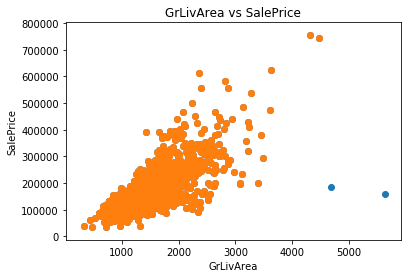

In [8]:
col = 'GrLivArea'
scatterc(train, train_y_name, col)
train = train.drop(train[(train[col] > 4000) & (train[train_y_name] < 300000)].index)
scatterc(train, train_y_name, col)
#plt.show()
#train = remove_outliers(train, col, 0.98)
#scatterc(train, train_y_name, col)
#plt.show()

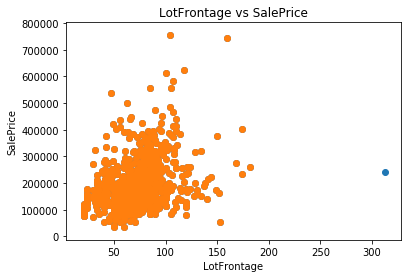

In [9]:
col = 'LotFrontage'
scatterc(train, train_y_name, col)
train = train.drop(train[(train[col] > 200)].index)
scatterc(train, train_y_name, col)

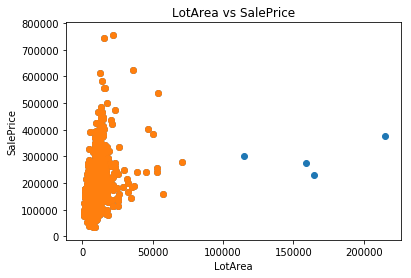

In [10]:
col = 'LotArea'
scatterc(train, train_y_name, col)
train = train.drop(train[(train[col] > 100000)].index)
scatterc(train, train_y_name, col)

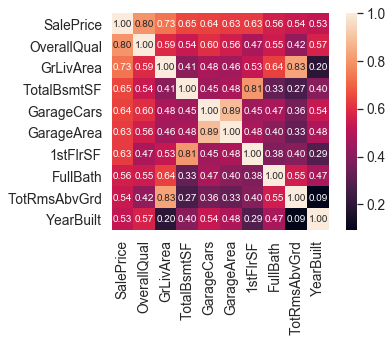

In [12]:
plot_correlation(train.select_dtypes(exclude=['object']), train_y_name, 10)

### Split Data

#### Split target from data

In [13]:
train_y = train[train_y_name].copy()
train_x = train.copy().drop([train_y_name], axis=1)

#### Combine all  x data

In [14]:
all_x = pd.concat([train_x, test_x], ignore_index=True)

#### Drop Id column

In [15]:
all_x = all_x.drop(['Id'], axis=1)

### Target

/Users/florianherborn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


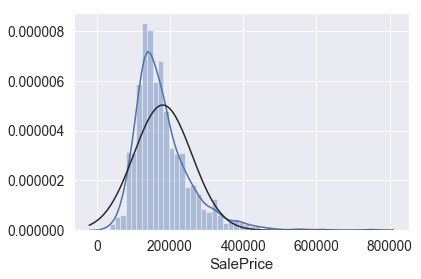

In [16]:
sns.distplot(train_y, fit=norm)

#### For better predictions we transfrom target to match the normal  distribution

In [17]:
#train_y = np.log1p(train_y)
#(mu, sigma) = norm.fit(train['SalePrice'])
#print( 'mu', mu, 'sigma', sigma)
#sns.distplot(train_y, fit=norm)

In [18]:
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
all_x['MSSubClass'] = all_x['MSSubClass'].apply(str)
all_x['YrSold'] = all_x['YrSold'].astype(str)
all_x['MoSold'] = all_x['MoSold'].astype(str)

### Missing Values

In [19]:
cols_with_missing = all_x.isna().sum()
cols_with_missing = cols_with_missing[cols_with_missing > 0].sort_values(ascending=False)
cols_with_missing

PoolQC          2899
MiscFeature     2805
Alley           2710
Fence           2337
FireplaceQu     1420
LotFrontage      480
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

#### Fill missing

In [20]:
all_x_prepared = all_x.copy()

##### PoolQC
The missing values of some features do not mean that there is no data, but that the described item does not exist. These values are replaced by 'None' in this step to consider them as additional classes in the following steps.

The following list contains all affected features:

In [21]:
defined_missing_values = [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]

In [22]:
for col in defined_missing_values:
    all_x_prepared[col] = all_x_prepared[col].fillna('None')


##### LotFrontage
LotFrontage: Linear feet of street connected to property

Check correlation between LotFrontage and and other columns

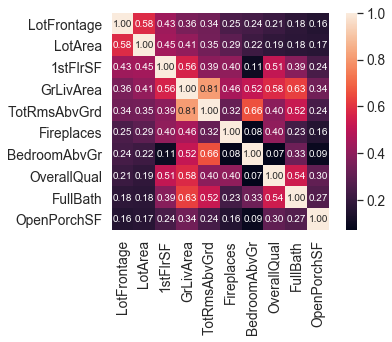

In [23]:
plot_correlation(all_x, 'LotFrontage', 10)

Correlation between LotFrontage and  LotArea use LinearRegression for predicting the missing value.We can use LotArea because there is no missing value and there is a correlation

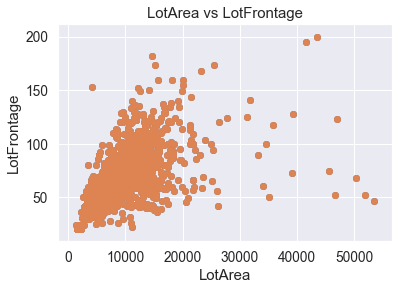

/Users/florianherborn/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


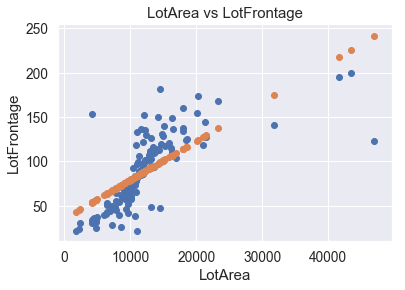

In [24]:
all_x_prepared = fill_by_linear_regression(all_x_prepared, 'LotFrontage', 'LotArea')

##### GarageYrBlt

Here it can be checked by means of associated values, if the year is missing, because no garage exists.

In [25]:
compare = all_x[['GarageYrBlt', 'GarageQual']]
compare = compare.loc[compare['GarageYrBlt'].isna() != compare['GarageQual'].isna()]
compare

,GarageYrBlt,GarageQual


The assumption seems to be correct, which is why the missing values are replaced by 0.

In [26]:
all_x_prepared['GarageYrBlt'] = all_x_prepared['GarageYrBlt'].fillna(0)

##### MasVnrType
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
Check if related values are missing. So it can be determined if a missing value means a missing Masonry veneer.
 

In [27]:
missing_mas_vnr = all_x[['MasVnrType', 'MasVnrArea']]
missing_mas_vnr.loc[missing_mas_vnr['MasVnrType'].isna() != missing_mas_vnr['MasVnrArea'].isna()]

,MasVnrType,MasVnrArea
2599,NaN,198.0


!!
Here a missing value was discovered with a non-missing associated value. So it can be assumed that the lack of this value does not mean that there is no Masonry veneer. However, since no high correlation could be found with any other value, the most used type is used here.

In [28]:
#all_x_prepared['MasVnrType'] = all_x_prepared['MasVnrType'].fillna(all_x['MasVnrType'].mode()[0])
all_x_prepared['MasVnrType'] = all_x_prepared['MasVnrType'].fillna('None')


##### MasVnrArea
MasVnrArea: Masonry veneer area in square feet

Check if there is a correlation with other values.

In [29]:
#plot_correlation(all_x_prepared, 'MasVnrArea', 10)

In [30]:
#all_x_prepared = fill_by_linear_regression(all_x_prepared, 'MasVnrArea', 'OverallQual')
all_x_prepared['MasVnrArea'] = all_x_prepared['MasVnrArea'].fillna(0)


##### MSZoning
MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

Although there are weak correlations, these are not completely unambiguous, which is why the most valuable value is taken here as well.

In [31]:
all_x_prepared['MasVnrType'] = all_x_prepared['MasVnrType'].fillna(all_x_prepared['MasVnrType'].mode()[0])

##### BsmtFullBath, BsmtHalfBath, TotalBsmtSF, BsmtUnfSF , BsmtFinSF2   & BsmtFinSF1    
BsmtFullBath: Basement full bathrooms
BsmtHalfBath: Basement half bathrooms
BsmtFinSF1: Type 1 finished square feet
BsmtFinSF2: Type 2 finished square feet
BsmtUnfSF: Unfinished square feet of basement area
TotalBsmtSF: Total square feet of basement area

Missing values for Basement Baths may be due to missing basements. So these are replaced by 0.

In [32]:
all_x_prepared['BsmtFullBath'] = all_x_prepared['BsmtFullBath'].fillna(0)
all_x_prepared['BsmtHalfBath'] = all_x_prepared['BsmtHalfBath'].fillna(0)
all_x_prepared['BsmtFinSF1'] = all_x_prepared['BsmtFinSF1'].fillna(0)
all_x_prepared['BsmtFinSF2'] = all_x_prepared['BsmtFinSF2'].fillna(0)
all_x_prepared['BsmtUnfSF'] = all_x_prepared['BsmtUnfSF'].fillna(0)
all_x_prepared['TotalBsmtSF'] = all_x_prepared['TotalBsmtSF'].fillna(0)

##### Utilities
Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	

In [33]:
all_x_prepared['Utilities'].describe()

count       2906
unique         2
top       AllPub
freq        2905
Name: Utilities, dtype: object

In [34]:
all_x_prepared[all_x_prepared['Utilities']!='AllPub']['Utilities']

935     NoSeWa
1904       NaN
1934       NaN
Name: Utilities, dtype: object

Here only 3 out of 2917 entries with a value other than 'AllPub' exist. So this column does not contribute to the result. That's why it's being dropped.

In [35]:
all_x_prepared = all_x_prepared.drop(['Utilities'], axis=1)

##### Functional
Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only

In [36]:
all_x_prepared['Functional'] = all_x_prepared['Functional'].fillna('Typ')

##### Exterior2nd & Exterior1st
Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
'If more than one material' then missing values are interpreted as no material present. However, since only one missing value exists, the creation of another dimension is avoided and the value is replaced by the most abundant material. 

In 'Exterior1st' also only 1 value is missing, which is replaced in the same way.

In [37]:
all_x_prepared['Exterior2nd'] = all_x_prepared['Exterior2nd'].fillna(all_x_prepared['Exterior2nd'].mode()[0])
all_x_prepared['Exterior1st'] = all_x_prepared['Exterior1st'].fillna(all_x_prepared['Exterior1st'].mode()[0])


##### SaleType, Electrical & KitchenQual

Again, only one value is missing, which is replaced with the most used one.

In [38]:
all_x_prepared['SaleType'] = all_x_prepared['SaleType'].fillna(all_x_prepared['SaleType'].mode()[0])
all_x_prepared['Electrical'] = all_x_prepared['Electrical'].fillna(all_x_prepared['Electrical'].mode()[0])
all_x_prepared['KitchenQual'] = all_x_prepared['KitchenQual'].fillna(all_x_prepared['KitchenQual'].mode()[0])


##### GarageCars & GarageArea

In [39]:
compare = all_x[['GarageCars', 'GarageArea', 'GarageQual']]
compare = compare.loc[compare['GarageCars'].isna() | compare['GarageArea'].isna()]
compare

,GarageCars,GarageArea,GarageQual
2565,NaN,NaN,NaN


We can see, that there is no value because there is no garage. So we can replace it with 0.

In [40]:
all_x_prepared['GarageCars'] = all_x_prepared['GarageCars'].fillna(0)
all_x_prepared['GarageArea'] = all_x_prepared['GarageArea'].fillna(0)

# Save numerical
numerical_cols = list(all_x_prepared.select_dtypes(exclude=['object']))

#### Prepare ordinal

In [41]:
all_x_prepared['TotalSF'] = all_x_prepared['TotalBsmtSF'] + all_x_prepared['1stFlrSF'] + all_x_prepared['2ndFlrSF']

def qual_mapper(x):
    return {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'None': 0,
    }.get(x, 0)

all_x_prepared['ExterQual'] = all_x_prepared['ExterQual'].apply(qual_mapper)
all_x_prepared['ExterCond'] = all_x_prepared['ExterCond'].apply(qual_mapper)
all_x_prepared['KitchenQual'] = all_x_prepared['KitchenQual'].apply(qual_mapper)
all_x_prepared['HeatingQC'] = all_x_prepared['HeatingQC'].apply(qual_mapper)
all_x_prepared['BsmtQual'] = all_x_prepared['BsmtQual'].apply(qual_mapper)
all_x_prepared['BsmtCond'] = all_x_prepared['BsmtCond'].apply(qual_mapper)
all_x_prepared['FireplaceQu'] = all_x_prepared['FireplaceQu'].apply(qual_mapper)
all_x_prepared['GarageQual'] = all_x_prepared['GarageQual'].apply(qual_mapper)
all_x_prepared['PoolQC'] = all_x_prepared['PoolQC'].apply(qual_mapper)

def slope_mapper(x):
    return {
        'Gtl': 0,
        'Mod': 1,
        'Sev': 2,
    }.get(x, 3)

all_x_prepared['LandSlope'] = all_x_prepared['LandSlope'].apply(slope_mapper)

def central_air_mapper(x):
    return {
        'N': 0,
    }.get(x, 1)

all_x_prepared['CentralAir'] = all_x_prepared['CentralAir'].apply(central_air_mapper) 

def street_mapper(x):
    return {
        'Pave': 1,
    }.get(x, 10)

all_x_prepared['Street'] = all_x_prepared['Street'].apply(street_mapper)

def paved_drive_mapper(x):
    return {
        'Y': 1,
    }.get(x, 0)

all_x_prepared['PavedDrive'] = all_x_prepared['PavedDrive'].apply(paved_drive_mapper)

def garage_fin_mapper(x):
    return {
        'Fin': 2,
        'RFn': 1,
        'Unf': 0,
    }.get(x, 0)

all_x_prepared['GarageFinish'] = all_x_prepared['GarageFinish'].apply(garage_fin_mapper)

def bsmt_exp_mapper(x):
    return {
        'Gd': 4,
        'Av': 3,
        'Mn': 2,
        'No': 1,
    }.get(x, 0)

all_x_prepared['BsmtExposure'] = all_x_prepared['BsmtExposure'].apply(bsmt_exp_mapper)

def func_mapper(x):
    return {
        'Typ': 0,
        'Min1': 1,
        'Min2': 1,
    }.get(x, 2)

#all_x_prepared['Functional_int'] = all_x_prepared['Functional'].apply(func_mapper)

def house_style_mapper(x):
    return {
        '1.5Unf': 0,
        'SFoyer': 1,
        '1.5Fin': 2,
        '2.5Unf': 3,
        'SLvl': 4,
        '1Story': 5,
        '2Story': 6,
        '2.5Fin': 7,
    }.get(x, 8)

#all_x_prepared['HouseStyle_int'] = all_x_prepared['HouseStyle'].apply(house_style_mapper)
#all_x_prepared['HouseStyle_1st'] = 1*(all_x_prepared['HouseStyle'] == '1Story')
#all_x_prepared['HouseStyle_2st'] = 1*(all_x_prepared['HouseStyle'] == '2Story')
#all_x_prepared['HouseStyle_15st'] = 1*(all_x_prepared['HouseStyle'] == '1.5Fin')

def foundation_mapper(x):
    return {
        'PConc': 3,
        'CBlock': 2,
        'BrkTil': 1,
    }.get(x, 0)

#all_x_prepared['Foundation_int'] = all_x_prepared['Foundation'].apply(foundation_mapper)

def mas_vnr_t_mapper(x):
    return {
        'Stone': 3,
        'BrkFace': 2,
        'BrkCmn': 1,
    }.get(x, 0)

#all_x_prepared['MasVnrType_int'] = all_x_prepared['MasVnrType'].apply(mas_vnr_t_mapper)

def bsmt_fin_t1_mapper(x):
    return {
        'GLQ': 6,
        'ALQ': 5,
        'BLQ': 4,
        'Rec': 3,
        'LwQ': 2,
        'Unf': 1,
    }.get(x, 0)

#all_x_prepared['BsmtFinType1_int'] = all_x_prepared['BsmtFinType1'].apply(bsmt_fin_t1_mapper)
#all_x_prepared['BsmtFinType1_Unf'] = 1*(all_x_prepared['BsmtFinType1'] == 'Unf')
#all_x_prepared['HasWoodDeck'] = (all_x_prepared['WoodDeckSF'] == 0) * 1
#all_x_prepared['HasOpenPorch'] = (all_x_prepared['OpenPorchSF'] == 0) * 1
#all_x_prepared['HasEnclosedPorch'] = (all_x_prepared['EnclosedPorch'] == 0) * 1
#all_x_prepared['Has3SsnPorch'] = (all_x_prepared['3SsnPorch'] == 0) * 1
#all_x_prepared['HasScreenPorch'] = (all_x_prepared['ScreenPorch'] == 0) * 1
#all_x_prepared['YearsSinceRemodel'] = all_x_prepared['YrSold'].astype(int) - all_x_prepared['YearRemodAdd'].astype(int)
#all_x_prepared['Total_Home_Quality'] = all_x_prepared['OverallQual'] + all_x_prepared['OverallCond']

In [42]:
#all_x_prepared = np.log1p(all_x_prepared[numerical_cols])

#### Encode nominal

In [43]:
nominal_cols = list(all_x_prepared.select_dtypes(include=['object']))
all_x_prepared = pd.get_dummies(all_x_prepared, columns=nominal_cols, drop_first=True)
all_x_prepared.shape


(2908, 252)

#### Scale Data

In [44]:
scaler = StandardScaler()
all_x_prepared = scaler.fit_transform(all_x_prepared)

/Users/florianherborn/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/florianherborn/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#### Split data

In [45]:
train_prepared_x = all_x_prepared[:train.shape[0]]
test_prepared_x = all_x_prepared[train.shape[0]:]

### Use PCA to reduce dimensions

In [46]:
seed = 7
np.random.seed(seed)

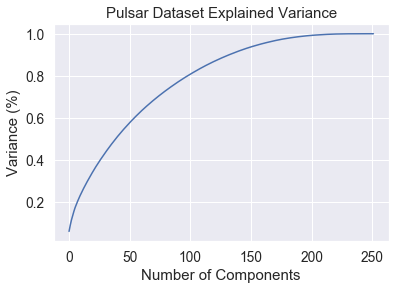

(1449, 196)

In [47]:
pca = PCA()
pca.fit(train_prepared_x, train_y)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')  # for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

variance = 0.99

nr_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= variance)

pca = PCA(n_components=nr_components)
pca.fit(train_prepared_x, train_y)

ann_train_x = pca.transform(train_prepared_x)
ann_test_x = pca.transform(test_prepared_x)
ann_train_x.shape

## ANN

In [48]:
# Create model
input_layer_nodes = ann_train_x.shape[1]
output_layer_nodes = 1

In [49]:

import keras
from keras.optimizers import RMSprop, Adam, Nadam, Adadelta
from keras.models import Sequential
from keras.layers import Dense, ThresholdedReLU
from keras import metrics

def build_model():
    model = Sequential()
    model.add(Dense(int(input_layer_nodes / 2), input_dim=input_layer_nodes, activation='relu'))
    model.add(Dense(int(input_layer_nodes / 5), activation=ThresholdedReLU(theta=1)))
    #model.add(Dense(50, activation='relu'))
    model.add(Dense(output_layer_nodes))
    #model.compile(optimizer=keras.optimizers.Adadelta(), loss='mean_squared_error', metrics=[metrics.mse])
    model.compile(optimizer='adadelta', loss='mean_squared_error', metrics=[metrics.mse])

    model.summary()
    return model





Using TensorFlow backend.


In [50]:
from keras.wrappers.scikit_learn import KerasRegressor
#from sklearn.model_selection import cross_val_score, KFold
#from sklearn.metrics import mean_squared_log_error
#from sklearn.model_selection import GridSearchCV


model = build_model()
#model = KerasRegressor(build_fn=build_model, epochs=125, batch_size=10, verbose=True)

#parameter = dict(
#    batch_size= [10, 25, 32],
#    epochs= [50, 75, 100, 125]
#)

#grid_search = GridSearchCV(estimator=estimator,
#                           param_grid=parameter,
#                           scoring='neg_mean_squared_log_error',
#                           cv=10)

#grid_search = grid_search.fit(ann_train_x, train_y)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 98)                19306     
_________________________________________________________________
dense_2 (Dense)              (None, 39)                3861      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 40        
Total params: 23,207
Trainable params: 23,207
Non-trainable params: 0
_________________________________________________________________


/Users/florianherborn/anaconda3/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as ThresholdedReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [51]:
#print('Best Parameters: ', grid_search.best_params_)
#print('Best Score: ', grid_search.best_score_)

In [52]:
#kfold = KFold(n_splits=10, random_state=seed)
#results = cross_val_score(estimator, ann_train_x, train_y, cv=kfold)
#print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))



history = model.fit(ann_train_x, train_y, epochs=125, batch_size=10)

#prediction = model.predict(ann_test_x)
#history = estimator.fit(ann_train_x, train_y)
prediction = model.predict(ann_test_x)
#prediction = np.expm1(prediction)

submission = pd.DataFrame()
submission['Id'] = test_id_col
submission['SalePrice'] = prediction
submission.to_csv('submission.csv', index=False)

target_submission = pd.read_csv('../input/good_submission.csv')

compare = submission
compare['Target'] = target_submission[train_y_name]
compare['Diff'] = submission[train_y_name] - target_submission[train_y_name]

def rmsle(ypred, ytest):
    assert len(ytest) == len(ypred)    
    return np.sqrt(np.mean((np.log1p(ypred) - np.log1p(ytest)) ** 2))

print('Error: ', rmsle(submission[train_y_name].tolist(), target_submission[train_y_name].tolist()))
print('Dollar loss: ', compare['Diff'].abs().mean())

print('Finished :-)')


Epoch 1/125
1449/1449 [==============================] - 0s 234us/step - loss: 23237111435.9475 - mean_squared_error: 23237111435.9475
Epoch 2/125
1449/1449 [==============================] - 0s 133us/step - loss: 1153147365.6094 - mean_squared_error: 1153147365.6094
Epoch 3/125
1449/1449 [==============================] - 0s 158us/step - loss: 539549878.7026 - mean_squared_error: 539549878.7026
Epoch 4/125
1449/1449 [==============================] - 0s 132us/step - loss: 436712228.1960 - mean_squared_error: 436712228.1960
Epoch 5/125
1449/1449 [==============================] - 0s 142us/step - loss: 408148230.0952 - mean_squared_error: 408148230.0952
Epoch 6/125
1449/1449 [==============================] - 0s 194us/step - loss: 391277720.2954 - mean_squared_error: 391277720.2954
Epoch 7/125
1449/1449 [==============================] - 0s 125us/step - loss: 383667202.7771 - mean_squared_error: 383667202.7771
Epoch 8/125
1449/1449 [==============================] - 0s 116us/step - loss

1449/1449 [==============================] - 0s 137us/step - loss: 272478320.7122 - mean_squared_error: 272478320.7122
Epoch 64/125
1449/1449 [==============================] - 0s 130us/step - loss: 270841389.1898 - mean_squared_error: 270841389.1898
Epoch 65/125
1449/1449 [==============================] - 0s 173us/step - loss: 270841963.8123 - mean_squared_error: 270841963.8123
Epoch 66/125
1449/1449 [==============================] - 0s 115us/step - loss: 267586481.6259 - mean_squared_error: 267586481.6259
Epoch 67/125
1449/1449 [==============================] - 0s 128us/step - loss: 265775021.3057 - mean_squared_error: 265775021.3057
Epoch 68/125
1449/1449 [==============================] - 0s 136us/step - loss: 264961683.6232 - mean_squared_error: 264961683.6232
Epoch 69/125
1449/1449 [==============================] - 0s 198us/step - loss: 263292820.6763 - mean_squared_error: 263292820.6763
Epoch 70/125
1449/1449 [==============================] - 0s 178us/step - loss: 262228388

Epoch 125/125
1449/1449 [==============================] - 0s 125us/step - loss: 190046823.6770 - mean_squared_error: 190046823.6770
Error:  0.07992266953618007
Dollar loss:  8749.081245617184
Finished :-)
